# LabelMe Dataset

* Input patterns: $256\times256$ real RGB images of landscapes.
* Labels: Mutually exclusive types of landscape.
    * Classes: *highway, insidecity, tallbuilding, street, forest, coast, mountain, opencountry*
* Ground truth: The original/real image landscape.
* Annotations: re-collected from Amazon Mechanical Turk (AMT).
    * Number of annotators (T) = 59  
    
    global labelme??

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    
np.set_printoptions(precision=4, suppress=True)

Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/casapanshop/anaconda2/envs/newpy3_tf1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 #rodrigues = BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder = "./data/LabelMe/"

### Load Data and preprocess

In [4]:
Xstd_train = np.load(folder+"LabelMe_VGG_avg_train.npy")
Z_train = np.loadtxt(folder+"LabelMe_Z_train.txt",dtype='int')

Xstd_val = np.load(folder+"LabelMe_VGG_avg_valid.npy")
Z_val = np.loadtxt(folder+"LabelMe_Z_valid.txt",dtype='int')

Xstd_test = np.load(folder+"LabelMe_VGG_avg_test.npy")
Z_test = np.loadtxt(folder+"LabelMe_Z_test.txt",dtype='int')

print("Input shape:",Xstd_train.shape)
print("Label shape:",Z_train.shape)

Input shape: (1000, 512)
Label shape: (1000,)


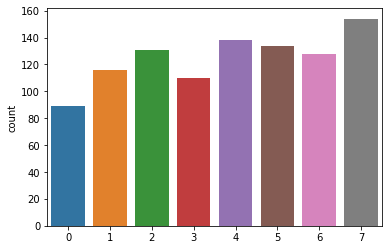

In [5]:
sns.countplot(Z_train)
plt.show()

### Load annotations 

In [21]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt",dtype='int16') #not annotation symbol ==-1

N,T = y_obs.shape
print("Shape (data,annotators): ",(N,T))
print("Classes: ",np.max(y_obs)+1)

Loading AMT data...
Shape (data,annotators):  (1000, 59)
Classes:  8


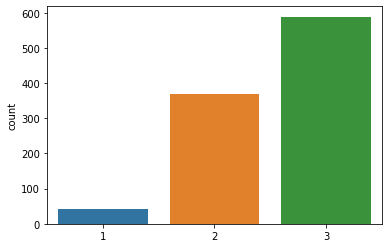

Minimum annotations in a example:  1
Maximum annotations in a example:  3
T data (expected value):  2.547
Graphics of T weights


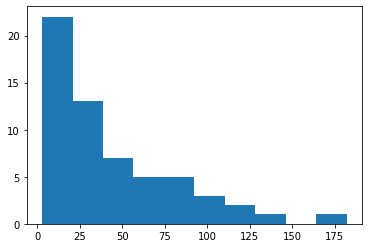

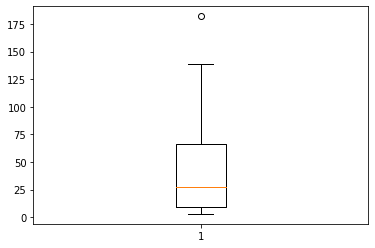

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  182
Mean annotations by an annotator:  43.16949152542373


In [7]:
N_ann = np.sum(y_obs != -1,axis=1) 

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) #number of annotations per annotator
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Upper Bound Model -- ideal

In [8]:
#### Delta Convergence criteria
from codeE.learning_models import MLP_Keras, Clonable_Model
from codeE.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

In [9]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_val_onehot = keras.utils.to_categorical(Z_val)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=False,drop=0.5) #true bn?
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback]
                  ,validation_data=(Xstd_val,Z_val_onehot))
clone_UB = Clonable_Model(model_UB, model_UB.input)
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 12


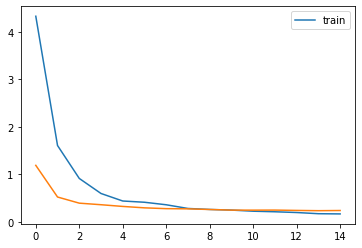

In [10]:
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [11]:
from codeE.evaluation import f1score_model
print("Train accuracy of model =", f1score_model(model_UB, Xstd_train, Z_train))
print("Test accuracy of model =", f1score_model(model_UB, Xstd_test, Z_test))

Train accuracy of model = 0.985754285157947
Test accuracy of model = 0.9339639485894673


### Generate Matrix representation of both scenarios

In [10]:
from codeE.representation import set_representation

y_obs_categorical = set_representation(y_obs,'onehot') 
print("Individual representation shape (N,T,K)= ",y_obs_categorical.shape)

r_obs = set_representation(y_obs,"global")
print("Global representation shape (N,K)= ",r_obs.shape)

Individual representation shape (N,T,K)=  (1000, 59, 8)
Global representation shape (N,K)=  (1000, 8)


### Real Confusion matrices
Generate the individual and global confusion matrices based on the sampled annotations.

In [11]:
from codeE.utils import generate_Individual_conf

conf_matrix_I = generate_Individual_conf(Z_train, y_obs_categorical)
print("Individual matrix shape (T,K,K)= ",conf_matrix_I.shape)
conf_matrix_I

Individual matrix shape (T,K,K)=  (59, 8, 8)


array([[[0.7778, 0.1111, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.7857, 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.2308, 0.7692, ..., 0.    , 0.    , 0.    ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 1.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.0556, 0.2222, 0.5556]],

       [[1.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.125 , 0.125 , 0.125 , ..., 0.125 , 0.125 , 0.125 ],
        ...,
        [0.    , 0.    , 0.    , ..., 1.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ],
        [0.    , 0.    , 0.    , ..., 0.    , 0.5   , 0.5   ]],

       [[0.375 , 0.125 , 0.    , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.75  , 0.25  , ..., 0.    , 0.    , 0.    ],
        [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
        ...,
        [0. 

Global matrix shape (K,K)=  (8, 8)


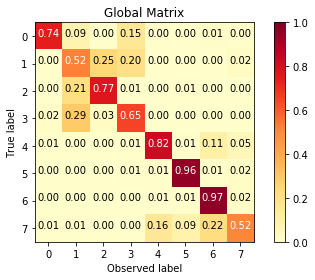

In [12]:
from codeE.utils import generate_Global_conf

#confe_matrix_G = generate_Global_conf(Z_train, y_obs_categorical)
confe_matrix_G = generate_Global_conf(Z_train, r_obs)
print("Global matrix shape (K,K)= ",confe_matrix_G.shape)

from codeE.utils import plot_confusion_matrix
plot_confusion_matrix(confe_matrix_G, np.arange(8), title= "Global Matrix")

## Aggregation methods (without predictive model)
* Majority Voting (MV)
* Weighted Majority Voting
* Dawid and Skene (DS): with inference

In [15]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="global")

mv_soft = label_A.infer(  r_obs, 'softMV')
mv_hard = label_A.predict(r_obs, 'hardMV')
mv_hard

array([1, 2, 1, 4, 5, 2, 0, 4, 2, 5, 0, 1, 2, 3, 1, 3, 6, 4, 7, 4, 1, 1,
       2, 1, 3, 6, 0, 4, 6, 2, 4, 3, 6, 6, 5, 7, 4, 0, 5, 4, 5, 5, 2, 0,
       4, 2, 1, 5, 1, 6, 1, 7, 1, 0, 1, 6, 6, 7, 4, 4, 2, 3, 0, 5, 1, 1,
       4, 5, 2, 6, 4, 1, 7, 6, 6, 1, 5, 6, 6, 4, 1, 3, 6, 5, 4, 5, 6, 4,
       0, 4, 7, 0, 3, 3, 5, 5, 7, 4, 1, 3, 5, 4, 4, 1, 7, 7, 6, 2, 4, 2,
       2, 1, 7, 4, 0, 7, 7, 4, 0, 1, 6, 4, 7, 7, 2, 2, 2, 4, 1, 3, 1, 6,
       0, 6, 6, 1, 6, 0, 4, 6, 0, 3, 0, 5, 7, 0, 4, 3, 2, 3, 4, 0, 5, 6,
       4, 3, 0, 6, 1, 7, 3, 1, 7, 2, 1, 7, 0, 3, 5, 5, 1, 0, 5, 2, 6, 2,
       5, 4, 2, 5, 5, 2, 5, 4, 3, 3, 6, 4, 0, 1, 0, 4, 7, 2, 5, 0, 7, 4,
       1, 0, 0, 5, 0, 3, 6, 4, 1, 7, 1, 1, 1, 4, 6, 5, 5, 4, 1, 6, 1, 2,
       1, 5, 5, 4, 4, 7, 2, 0, 2, 0, 1, 5, 2, 4, 3, 5, 6, 6, 1, 1, 4, 1,
       6, 4, 2, 6, 2, 7, 5, 4, 3, 4, 2, 7, 6, 4, 2, 1, 5, 7, 3, 3, 5, 6,
       1, 6, 6, 1, 7, 3, 5, 2, 6, 5, 1, 1, 6, 1, 1, 5, 1, 4, 4, 1, 5, 3,
       6, 2, 6, 4, 3, 6, 1, 4, 1, 3, 6, 0, 2, 6, 0,

In [16]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

mv_soft = label_A.infer(  y_obs_categorical, 'softMV')
mv_hard = label_A.predict(y_obs_categorical, 'hardMV')
mv_soft

array([[0.    , 0.6667, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.6667, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3333, 0.3333, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.3333, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [17]:
print("ACC MV on train:",np.mean(mv_hard==Z_train))

ACC MV on train: 0.769


### generate confusion matrix to understand MV

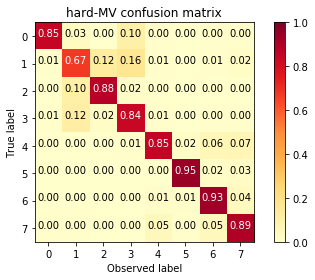

In [19]:
prob_Yz = generate_confusionM(mv_hard, r_obs) #confusion matrix of all annotators
plot_confusion_matrix(prob_Yz, np.arange(8), title= "hard-MV confusion matrix")

### Metrics to compare the estimation of confusion matrix

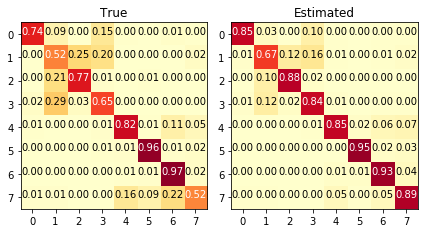

In [21]:
from codeE.utils import compare_conf_ma
compare_conf_ma(prob_Yz, true_conf_mat=confe_matrix_G, text=True)

In [22]:
from codeE.evaluation import D_JS, D_KL, D_NormF
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


##### Weighted

In [23]:
from codeE.methods import LabelAgg
label_A = LabelAgg(scenario="individual")

Wmv_soft = label_A.infer(y_obs_categorical, 'softMV', weights=T_weights)
Wmv_soft

array([[0.    , 0.3309, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.3374, 0.6626, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.306 , 0.1913, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0848, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [24]:
print("ACC MV on train:",np.mean(Wmv_soft.argmax(axis=-1)==Z_train))

ACC MV on train: 0.762


### Dawid and Skene model

In [25]:
from codeE.methods import LabelInf_EM as DS

DS_model = DS(init_Z='softmv') 
#DS_model = DS(init_Z='softmv', priors="None", fast=False) 
    
# if you want you can initialize step E forcing some method
#DS_model.init_E(y_obs_categorical)
#DS_model.get_qestimation()

hist = DS_model.fit(y_obs_categorical, max_iter=EPOCHS_BASE, tolerance=TOL)

Initializing new EM...
Z marginal shape (8,)
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2837.160	
Iter 2/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2760.562	Tol1: 0.02700	Tol2: 0.25264	
Iter 3/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2734.589	Tol1: 0.00941	Tol2: 0.10178	
Iter 4/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2723.378	Tol1: 0.00410	Tol2: 0.08455	
Iter 5/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2717.710	Tol1: 0.00208	Tol2: 0.14913	
Iter 6/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2714.123	Tol1: 0.00132	Tol2: 0.30754	
Iter 7/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2712.104	Tol1: 0.00074	Tol2: 0.13994	
Iter 8/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2710.701	Tol1: 0.00052	Tol2: 0.05798	
Iter 9/50 
M step: done,  E step: done //  (in 0.00 sec)	logL: -2709.480	Tol1: 0.00045	Tol2: 0.04514	
Iter 10/50 

In [26]:
print("p(z) = ",DS_model.get_marginalZ())

ds_labels = DS_model.infer() #could infer/predict on the trainint set only
ds_labels

p(z) =  [0.0766 0.1127 0.1443 0.1139 0.1431 0.1434 0.1716 0.0944]


array([[0.    , 0.0633, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.1574, 0.8426, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.999 , 0.    , ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.0345, 0.    , ..., 0.    , 0.    , 0.    ],
       [0.    , 0.0022, 0.9978, ..., 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , ..., 0.    , 0.    , 1.    ]],
      dtype=float32)

In [27]:
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC D&S on train: 0.804


### Second Phase
train a predictive model over the inference/aggregation label

In [28]:
from codeE.evaluation import accuracy_model

In [29]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvsoft, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvsoft, Xstd_test, Z_test))

Trained model over soft-MV, Epochs to converge = 10
Train accuracy of model = 0.849
Test accuracy of model = 0.8207070707070707


In [30]:
mv_hard_onehot = keras.utils.to_categorical(mv_hard)
mv_hard_onehot

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [31]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_hard_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_mvhard, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_mvhard, Xstd_test, Z_test))

Trained model over hard-MV, Epochs to converge = 16
Train accuracy of model = 0.795
Test accuracy of model = 0.7845117845117845


In [32]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))

print("Train accuracy of model =", accuracy_model(model_ds, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(model_ds, Xstd_test, Z_test))

Trained model over D&S, Epochs to converge = 9
Train accuracy of model = 0.855
Test accuracy of model = 0.8417508417508418


## Raykar Model (joint predict model)

In [33]:
model_R = clone_UB.get_model()
model_R.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [34]:
from codeE.methods import ModelInf_EM as Raykar
R_model = Raykar(init_Z="softmv")
#R_model = Raykar(init_Z="softmv", priors='laplace', n_init_Z=3)

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
R_model.set_model(model_R, **args)

# if you want you can initialize step E forcing some method
#R_model.init_E(y_obs_categorical, method="hardmv")
#R_model.get_qestimation()

In [36]:
#logL_hists,i_r = R_model.multiples_run(20, Xstd_train,y_obs_categorical,
#                                        max_iter=EPOCHS_BASE, tolerance=TOL)

R_model.fit(Xstd_train, y_obs_categorical, runs=20, max_iter=EPOCHS_BASE, tolerance=TOL)

Iter 1/50 
M step: done,  E step: done //  (in 0.41 sec)	logL: -2073.720	
Iter 2/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -1291.177	Tol1: 0.37736	Tol2: 0.34979	
Iter 3/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -1152.130	Tol1: 0.10769	Tol2: 0.16268	
Iter 4/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1089.211	Tol1: 0.05461	Tol2: 9.78506	
Iter 5/50 
M step: done,  E step: done //  (in 0.03 sec)	logL: -1049.157	Tol1: 0.03677	Tol2: 0.24767	
Iter 6/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -1021.500	Tol1: 0.02636	Tol2: 2.97424	
Iter 7/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -998.775	Tol1: 0.02225	Tol2: 0.48186	
Iter 8/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -977.717	Tol1: 0.02108	Tol2: 0.46335	
Iter 9/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -959.965	Tol1: 0.01816	Tol2: 0.01806	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step:

M step: done,  E step: done //  (in 0.02 sec)	logL: -971.962	Tol1: 0.02257	Tol2: 0.10235	
Iter 9/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -953.553	Tol1: 0.01894	Tol2: 0.06406	
Iter 10/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -936.016	Tol1: 0.01839	Tol2: 0.04198	
Iter 11/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -925.363	Tol1: 0.01138	Tol2: 0.03199	
Iter 12/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -914.934	Tol1: 0.01127	Tol2: 0.03132	
Iter 13/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -903.824	Tol1: 0.01214	Tol2: 0.02977	
Finished training
Initializing new EM...
Betas shape:  (59, 8, 8)
Q estimate shape:  (1000, 8)
Iter 1/50 
M step: done,  E step: done //  (in 0.41 sec)	logL: -1968.150	
Iter 2/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -1326.985	Tol1: 0.32577	Tol2: 0.31264	
Iter 3/50 
M step: done,  E step: done //  (in 0.02 sec)	logL: -1196.516	Tol1: 0.09832	Tol2: 0.13630	
Iter 4/50 
M step: done,  E 

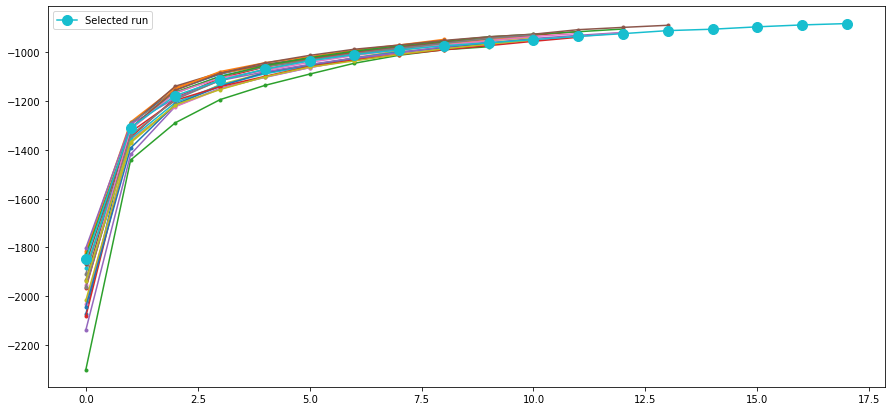

In [37]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): 
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [38]:
raykar_fx = R_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(raykar_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(raykar_fx, Xstd_test, Z_test))

Train accuracy of model = 0.861
Test accuracy of model = 0.8678451178451179


## Our Proposed - CMM

In [13]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


In [14]:
from codeE.methods import ModelInf_EM_CMM as  CMM
CMM_model = CMM(M=M_seted) 
#CMM_model = CMM(M=M_seted, init_Z='softmv', n_init_Z=3, priors=0) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMM_model.set_model(aux_model, **args)

# if you want you can initialize step E forcing some method
#CMM_model.init_E(r_obs, method="hardmv")
#CMM_model.get_qestimation()

In [15]:
#logL_hists,i_r = CMM_model.multiples_run(20,Xstd_train,r_obs,
#                                               max_iter=EPOCHS_BASE,tolerance=TOL)

CMM_model.fit(Xstd_train, r_obs, runs =20,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -3087.918	
Iter 2/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -2179.542	Tol1: 0.29417	Tol2: 0.98928	Tol3: 0.13844	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1958.830	Tol1: 0.10127	Tol2: 0.37705	Tol3: 0.04908	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1852.831	Tol1: 0.05411	Tol2: 0.23184	Tol3: 0.03448	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1767.701	Tol1: 0.04595	Tol2: 0.19988	Tol3: 0.00978	
Iter 6/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1719.248	Tol1: 0.02741	Tol2: 0.16517	Tol3: 0.01617	
Iter 7/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1677.124	Tol1: 0.02450	Tol2: 0.14684	Tol3: 0.02082	
Iter 8/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1644.093	Tol1: 0.01970	Tol2: 0.11823	Tol3: 0.01732	
Iter 9/50
M s

M step: done,  E step: done //  (in 0.41 sec)	logL: -2833.551	
Iter 2/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -2032.337	Tol1: 0.28276	Tol2: 0.57732	Tol3: 0.10405	
Iter 3/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1825.594	Tol1: 0.10173	Tol2: 0.42891	Tol3: 0.04657	
Iter 4/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1741.125	Tol1: 0.04627	Tol2: 0.25193	Tol3: 0.01324	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1689.550	Tol1: 0.02962	Tol2: 0.18742	Tol3: 0.00857	
Iter 6/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1644.511	Tol1: 0.02666	Tol2: 0.14319	Tol3: 0.00439	
Iter 7/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1611.901	Tol1: 0.01983	Tol2: 0.12971	Tol3: 0.01180	
Iter 8/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1576.307	Tol1: 0.02208	Tol2: 0.10106	Tol3: 0.01208	
Iter 9/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1542.777	Tol1: 0.02127	Tol2: 0.09008	Tol3: 0.01521	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.03 sec)	logL: -1320.244	Tol1: 0.01575	Tol2: 0.04001	Tol3: 0.00707	
Iter 19/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1300.489	Tol1: 0.01496	Tol2: 0.03844	Tol3: 0.00364	
Iter 20/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1285.167	Tol1: 0.01178	Tol2: 0.03408	Tol3: 0.00687	
Iter 21/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1273.389	Tol1: 0.00916	Tol2: 0.03777	Tol3: 0.00811	
Iter 22/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1263.138	Tol1: 0.00805	Tol2: 0.03016	Tol3: 0.00526	
Iter 23/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1250.065	Tol1: 0.01035	Tol2: 0.03656	Tol3: 0.01030	
Iter 24/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1237.480	Tol1: 0.01007	Tol2: 0.03238	Tol3: 0.00811	
Iter 25/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1225.527	Tol1: 0.00966	Tol2: 0.03410	Tol3: 0.00357	
Iter 26/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1211.872	Tol1: 0.01

M step: done,  E step: done //  (in 0.03 sec)	logL: -1397.220	Tol1: 0.00906	Tol2: 0.04327	Tol3: 0.00360	
Iter 20/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1380.500	Tol1: 0.01197	Tol2: 0.03837	Tol3: 0.00558	
Iter 21/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1367.156	Tol1: 0.00967	Tol2: 0.02523	Tol3: 0.00436	
Finished training!
Initializing new EM...
Doing clustering...Done!
Alphas:  (3,)
Betas:  (3, 8, 8)
Q estimate:  (1000, 8, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.40 sec)	logL: -3560.686	
Iter 2/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -2229.301	Tol1: 0.37391	Tol2: 1.74327	Tol3: 0.13252	
Iter 3/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1917.048	Tol1: 0.14007	Tol2: 0.40479	Tol3: 0.03695	
Iter 4/50
M step: done,  E step: done //  (in 0.04 sec)	logL: -1781.939	Tol1: 0.07048	Tol2: 0.30384	Tol3: 0.06315	
Iter 5/50
M step: done,  E step: done //  (in 0.03 sec)	logL: -1700.977	Tol1: 0.04543	Tol2: 0.22515	Tol3: 0.07001	
It

([array([-3087.9176, -2179.5421, -1958.8298, -1852.831 , -1767.7008,
         -1719.2477, -1677.124 , -1644.093 , -1615.9002, -1580.8918,
         -1559.3194, -1536.591 , -1511.5911, -1495.9975, -1483.5892,
         -1473.252 , -1458.4785, -1444.7872, -1431.3862, -1417.8154,
         -1404.7675, -1396.0437, -1385.3777, -1375.4213, -1370.8661,
         -1365.6631]),
  array([-3086.7677, -2154.6232, -1921.3216, -1805.8324, -1729.5437,
         -1675.9079, -1628.7846, -1591.3631, -1562.618 , -1533.826 ,
         -1505.2654, -1487.207 , -1460.5358, -1436.7578, -1415.8399,
         -1402.7974, -1380.8897, -1364.3783, -1347.2049]),
  array([-3008.4101, -2093.1367, -1858.7452, -1768.8168, -1704.8302,
         -1650.221 , -1598.0621, -1555.6227, -1526.5106, -1499.7103,
         -1471.6645, -1444.3519, -1420.3038, -1404.2022, -1388.5316,
         -1374.4119, -1358.6301, -1341.6964, -1329.5704, -1312.8184,
         -1302.5264, -1295.6177, -1284.8885, -1275.6788, -1266.408 ,
         -1257.2559, 

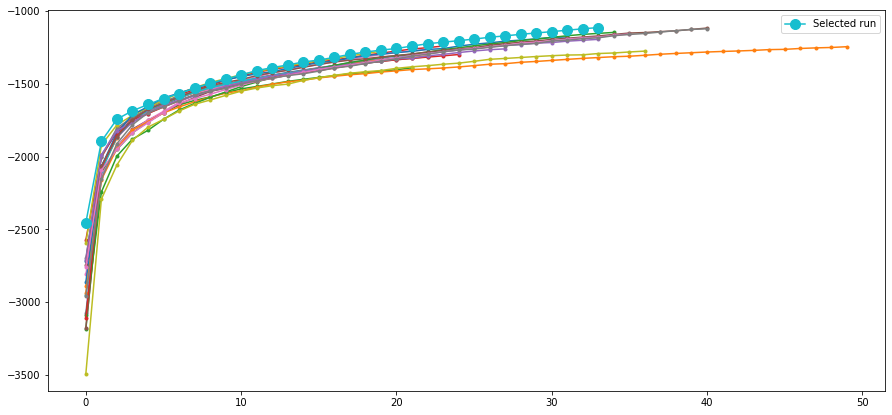

In [24]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [42]:
cmm_fx = CMM_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmm_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmm_fx, Xstd_test, Z_test))

Train accuracy of model = 0.833
Test accuracy of model = 0.8249158249158249


### Groups found

In [47]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9842 0.0127 0.0031]


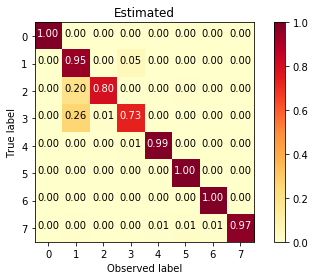

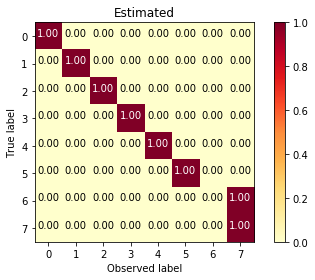

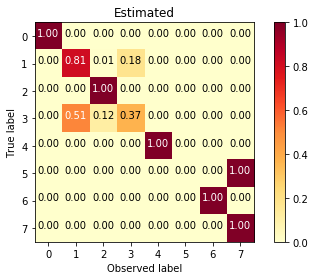

In [48]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

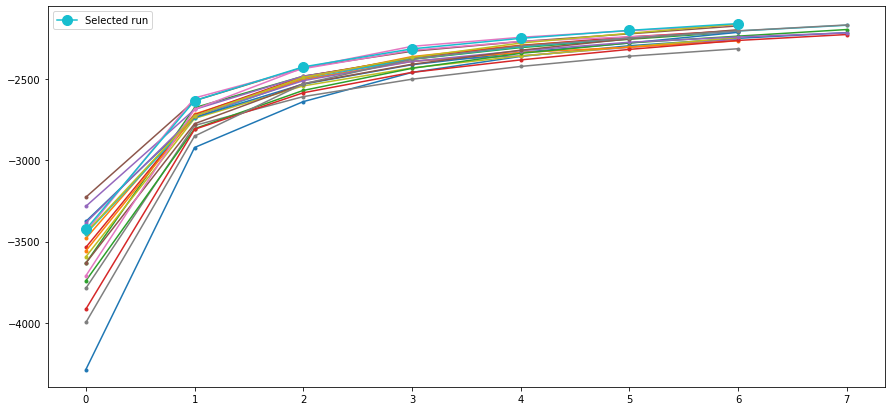

In [17]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [40]:
print("p(g) =",CMM_model.get_alpha())

p(g) = [0.9987 0.0011 0.0002]


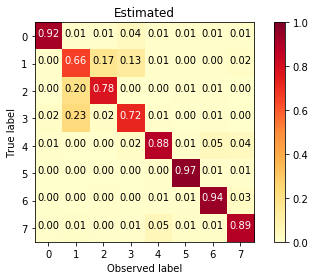

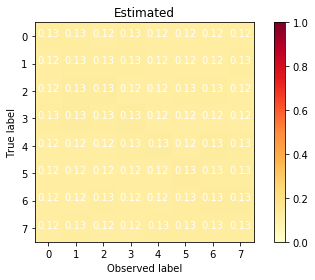

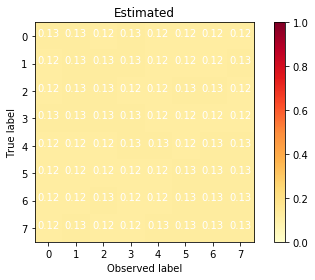

In [41]:
B = CMM_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Our Proposed - C-MoA

#### Auxiliar representation with variable number of annotations per annotator and identity

In [16]:
y_cat_var, A_idx_var = set_representation(y_obs,"onehotvar")
print("Individual sparse representation, variable shape (N,)= ",y_cat_var.shape)
K = y_cat_var[0].shape[1]
print("one-hot vectors of K-dimensions, K=",K)
y_cat_var

Individual sparse representation, variable shape (N,)=  (1000,)
one-hot vectors of K-dimensions, K= 8


array([array([[0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0]], dtype=int8),
       array([[0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0]], dtype=int8),
       array([[0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0]], dtype=int8),
       array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0

In [17]:
M_seted = 3

aux_model = clone_UB.get_model()
aux_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
Total params: 66,696
Trainable params: 66,696
Non-trainable params: 0
_________________________________________________________________


#### Fixed annotators representation (non trainable embedding)

In [18]:
T= np.concatenate(A_idx_var).max() +1
A_rep = np.zeros((T, K))
for i in range(N):
    for l, t_idx in enumerate(A_idx_var[i]):
        obs_t = y_cat_var[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
print("shape of annotator representation (T, R_t)=", A_rep.shape)

shape of annotator representation (T, R_t)= (59, 8)


In [19]:
from keras.models import Sequential
from keras.layers import *
group_model = Sequential()
group_model.add(Embedding(T, K, input_length=1, 
                         trainable=False,weights=[A_rep]))
                         #trainable=True))
group_model.add(Reshape([K]))
group_model.add(Dense(K*M_seted, activation='relu'))
group_model.add(Dense(M_seted, activation='softmax'))
group_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1, 8)              472       
_________________________________________________________________
reshape_1 (Reshape)          (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                216       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 75        
Total params: 763
Trainable params: 291
Non-trainable params: 472
_________________________________________________________________


In [20]:
from codeE.methods import ModelInf_EM_CMOA as CMOA
CMOA_model = CMOA(M=M_seted) 
#CMOA_model = CMOA(M=M_seted, init_Z='softmv', n_init_Z=0, n_init_G=0, priors=1) 

args = {'epochs':1, 'batch_size':BATCH_SIZE, 'optimizer':OPT}
CMOA_model.set_model(aux_model, ann_model=group_model, **args)
#CMOA_model.set_model(group_model) #you also can set it manually

# if you want you can initialize step E forcing some method
#CMOA_model.init_E(y_cat_var, A_idx_var, method="hardmv")
#CMOA_model.get_qestimation()

In [21]:
#logL_hists,i_r = CMOA_model.multiples_run(20,Xstd_train,y_cat_var, A_idx_var, 
#                                   max_iter=EPOCHS_BASE,tolerance=TOL) 

CMOA_model.fit(Xstd_train, y_cat_var, A_idx_var, runs = 20,max_iter=EPOCHS_BASE,tolerance=TOL) 

Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.86 sec)	logL: -2584.812	
Iter 2/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1994.297	Tol1: 0.22846	Tol2: 0.41869	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1842.761	Tol1: 0.07599	Tol2: 0.36688	
Iter 4/50
M step: done,  E step: done //  (in 0.07 sec)	logL: -1709.076	Tol1: 0.07255	Tol2: 0.36644	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1624.993	Tol1: 0.04920	Tol2: 0.27327	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1575.116	Tol1: 0.03069	Tol2: 0.26088	
Iter 7/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.519	Tol1: 0.02831	Tol2: 0.21428	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1493.686	Tol1: 0.02407	Tol2: 0.17177	
Iter 9/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1463.051	Tol1: 0.02051	Tol2: 0.14815	
Iter 10/50
M step: done,  E

M step: done,  E step: done //  (in 0.05 sec)	logL: -1096.197	Tol1: 0.00356	Tol2: 0.02761	
Finished training!
Initializing new EM...
Doing clustering...Done!
Betas:  (3, 8, 8)
Q estimate:  (2547, 3, 8)
Iter 1/50
M step: done,  E step: done //  (in 0.75 sec)	logL: -2887.299	
Iter 2/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -2057.577	Tol1: 0.28737	Tol2: 0.81851	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1845.080	Tol1: 0.10328	Tol2: 0.67319	
Iter 4/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1720.938	Tol1: 0.06728	Tol2: 0.45696	
Iter 5/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1655.742	Tol1: 0.03788	Tol2: 0.33341	
Iter 6/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1607.378	Tol1: 0.02921	Tol2: 0.25775	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1567.312	Tol1: 0.02493	Tol2: 0.18840	
Iter 8/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1530.376	Tol1: 0.02357	Tol2: 0.14632	
Iter 9/50
M step: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -2131.621	Tol1: 0.27133	Tol2: 0.60598	
Iter 3/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1930.658	Tol1: 0.09428	Tol2: 0.48141	
Iter 4/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1822.038	Tol1: 0.05626	Tol2: 0.58706	
Iter 5/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1764.106	Tol1: 0.03180	Tol2: 0.39739	
Iter 6/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1719.764	Tol1: 0.02514	Tol2: 0.25051	
Iter 7/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1672.566	Tol1: 0.02744	Tol2: 0.17422	
Iter 8/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1637.436	Tol1: 0.02100	Tol2: 0.15628	
Iter 9/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1610.453	Tol1: 0.01648	Tol2: 0.13554	
Iter 10/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1589.255	Tol1: 0.01316	Tol2: 0.12157	
Iter 11/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1563.019	Tol1: 0.01651	Tol2: 0.11672

M step: done,  E step: done //  (in 0.05 sec)	logL: -1249.463	Tol1: 0.00337	Tol2: 0.04223	
Iter 33/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1242.766	Tol1: 0.00536	Tol2: 0.04741	
Iter 34/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1231.378	Tol1: 0.00916	Tol2: 0.04035	
Iter 35/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1223.282	Tol1: 0.00657	Tol2: 0.04110	
Iter 36/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1214.018	Tol1: 0.00757	Tol2: 0.03579	
Iter 37/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1207.232	Tol1: 0.00559	Tol2: 0.03320	
Iter 38/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1200.937	Tol1: 0.00521	Tol2: 0.03404	
Iter 39/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1193.732	Tol1: 0.00600	Tol2: 0.03258	
Iter 40/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1187.606	Tol1: 0.00513	Tol2: 0.03395	
Iter 41/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1182.896	Tol1: 0.00397	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1353.637	Tol1: 0.01304	Tol2: 0.09121	
Iter 15/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1334.877	Tol1: 0.01386	Tol2: 0.08305	
Iter 16/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1317.723	Tol1: 0.01285	Tol2: 0.07835	
Iter 17/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1302.163	Tol1: 0.01181	Tol2: 0.06548	
Iter 18/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1289.516	Tol1: 0.00971	Tol2: 0.05643	
Iter 19/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1277.949	Tol1: 0.00897	Tol2: 0.04828	
Iter 20/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1264.551	Tol1: 0.01048	Tol2: 0.04546	
Iter 21/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1249.407	Tol1: 0.01198	Tol2: 0.04564	
Iter 22/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1235.038	Tol1: 0.01150	Tol2: 0.04276	
Iter 23/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1228.826	Tol1: 0.00503	Tol2: 

M step: done,  E step: done //  (in 0.06 sec)	logL: -1343.474	Tol1: 0.01172	Tol2: 0.04645	
Iter 23/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1335.612	Tol1: 0.00585	Tol2: 0.04842	
Iter 24/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1315.896	Tol1: 0.01476	Tol2: 0.04485	
Iter 25/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1296.943	Tol1: 0.01440	Tol2: 0.03993	
Iter 26/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1283.965	Tol1: 0.01001	Tol2: 0.05008	
Iter 27/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1268.331	Tol1: 0.01218	Tol2: 0.04742	
Iter 28/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1256.790	Tol1: 0.00910	Tol2: 0.04629	
Iter 29/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1246.021	Tol1: 0.00857	Tol2: 0.03938	
Iter 30/50
M step: done,  E step: done //  (in 0.06 sec)	logL: -1241.386	Tol1: 0.00372	Tol2: 0.04129	
Iter 31/50
M step: done,  E step: done //  (in 0.05 sec)	logL: -1231.304	Tol1: 0.00812	Tol2: 

([array([-2584.8121, -1994.2974, -1842.7606, -1709.0755, -1624.9926,
         -1575.1156, -1530.519 , -1493.6856, -1463.0513, -1432.9824,
         -1413.9595, -1395.9442, -1371.4974, -1353.6298, -1341.4709,
         -1327.8363, -1315.9811, -1306.7157, -1293.5996, -1282.0259,
         -1272.926 , -1263.4009, -1252.0285, -1242.0254, -1231.2824,
         -1225.1262, -1213.2668, -1208.7806, -1199.2402, -1188.6977,
         -1178.8698, -1168.9197, -1162.1672]),
  array([-3469.1404, -2231.47  , -1931.0142, -1802.5727, -1722.4232,
         -1669.3948, -1617.6671, -1578.6435, -1541.8563, -1518.5626,
         -1488.2808, -1465.6992, -1446.9286, -1427.5908, -1409.3748,
         -1390.6592, -1378.2927, -1364.181 , -1350.0201, -1339.0017,
         -1325.7274, -1311.9026, -1297.708 , -1289.1858, -1279.9389,
         -1266.1653, -1256.0842, -1241.5441, -1232.5305, -1221.9011,
         -1213.8684, -1200.8049, -1191.8516, -1183.3477, -1176.1143,
         -1168.8064, -1163.5587, -1154.2821, -1146.4078,

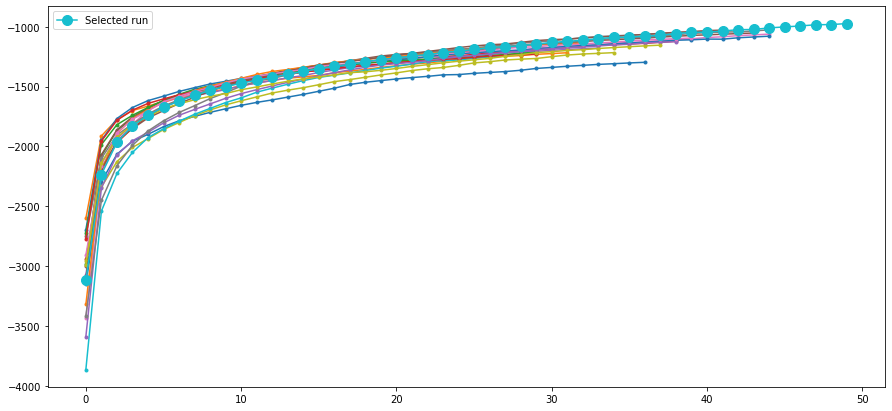

In [20]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [49]:
cmoaK_fx = CMOA_model.get_basemodel()

from codeE.evaluation import accuracy_model
print("Train accuracy of model =", accuracy_model(cmoaK_fx, Xstd_train, Z_train))
print("Test accuracy of model =", accuracy_model(cmoaK_fx, Xstd_test, Z_test))

Train accuracy of model = 0.838
Test accuracy of model = 0.8560606060606061


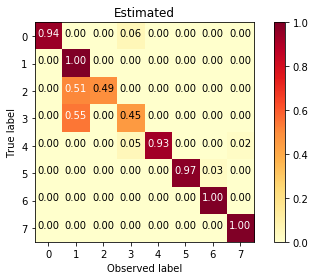

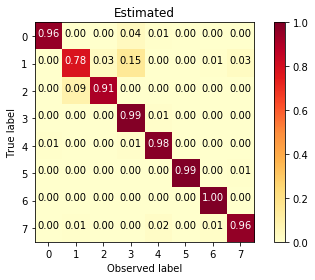

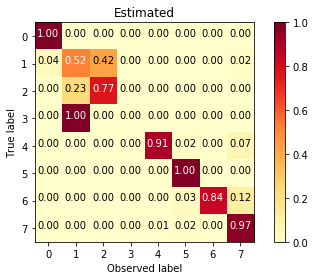

In [23]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

#### With priors= "laplace"
smooth confusion matrices

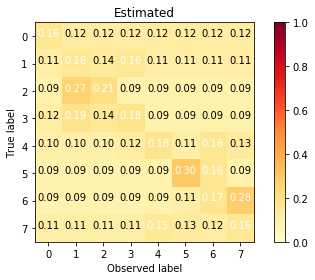

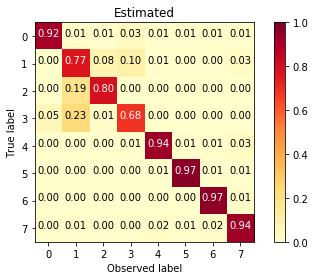

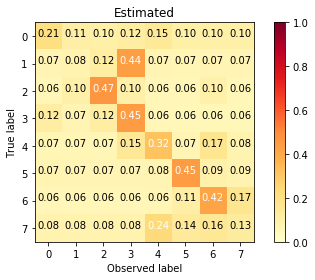

In [52]:
B = CMOA_model.get_confusionM()
for i in range(len(B)):
    plot_confusion_matrix(B[i])

## Confusion Matrices Visualization

In [22]:
from codeE.utils import generate_confusionM
from codeE.utils import plot_confusion_matrix, compare_conf_ma, compare_set_conf_ma
from codeE.evaluation import Individual_D, D_JS, D_NormF

### Global scenario

#### MV

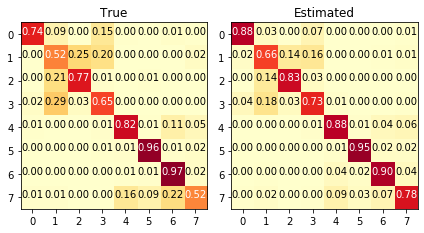

Global D (based on Jensen Shannon) = 0.024224901133546403
Global D (based on normalized Frobenius) = 0.05655808001756668


In [104]:
### SOFT
prob_Yz = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotations
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

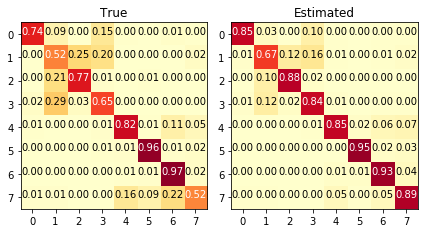

Global D (based on Jensen Shannon) = 0.03469416227325334
Global D (based on normalized Frobenius) = 0.07360906898975372


In [105]:
### HARD
prob_Yz = generate_confusionM(mv_hard, r_obs) 
compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

#### CMM

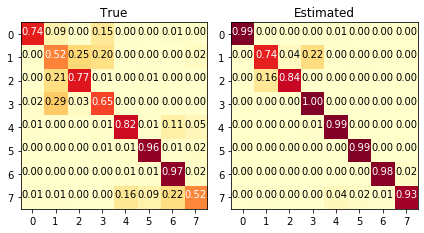

Global D (based on Jensen Shannon) = 0.09207412096186926
Global D (based on normalized Frobenius) = 0.10333766580775834


In [106]:
prob_Yz = CMM_model.get_global_confusionM()

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

### Individual scenario

#### DS

Plot 5 random matrices from the set


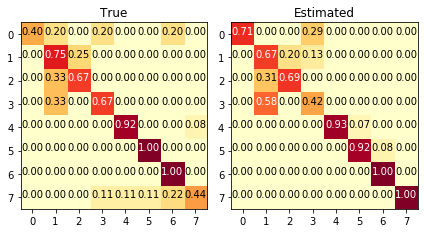

D (based on Jensen Shannon) = 0.1028862023726475
D (based on normalized Frobenius) = 0.10835600644350052


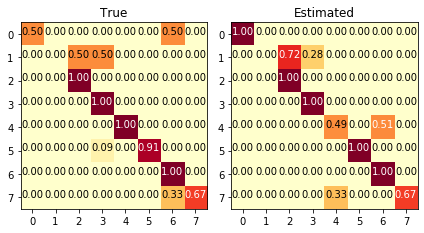

D (based on Jensen Shannon) = 0.13076348293919385
D (based on normalized Frobenius) = 0.1452639400959015


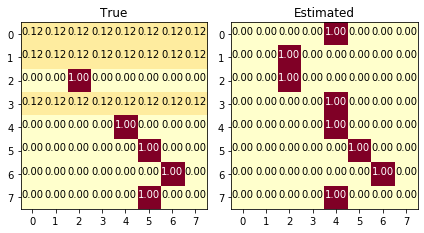

D (based on Jensen Shannon) = 0.39383958254522833
D (based on normalized Frobenius) = 0.2688226103782654


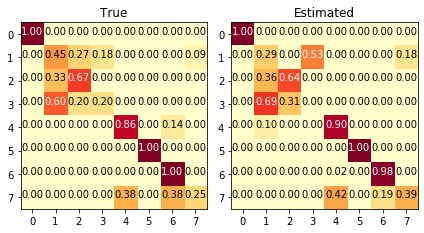

D (based on Jensen Shannon) = 0.06276360120539184
D (based on normalized Frobenius) = 0.07707014679908752


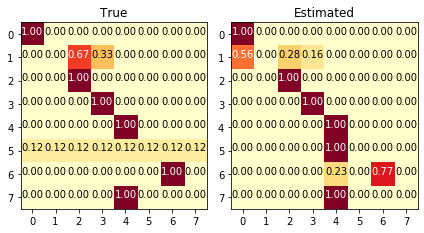

D (based on Jensen Shannon) = 0.15052209674453207
D (based on normalized Frobenius) = 0.15180274844169617


In [107]:
prob_Yzt = DS_model.get_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [108]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.18280751182126098
Individual D_NormF =  0.14954937672463514


#### Raykar

Plot 5 random matrices from the set


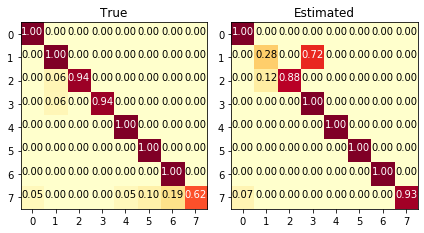

D (based on Jensen Shannon) = 0.09238574787964034
D (based on normalized Frobenius) = 0.13603684306144714


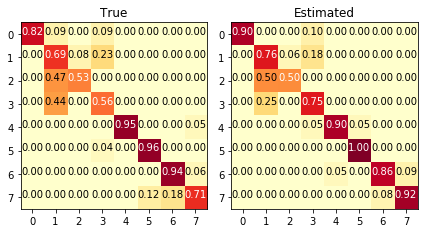

D (based on Jensen Shannon) = 0.035729497831447445
D (based on normalized Frobenius) = 0.05462805554270744


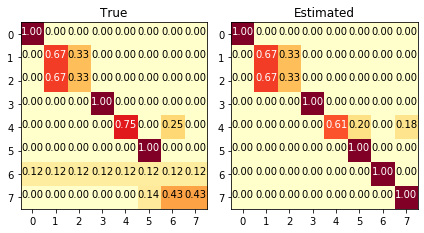

D (based on Jensen Shannon) = 0.17632602971468617
D (based on normalized Frobenius) = 0.1562100201845169


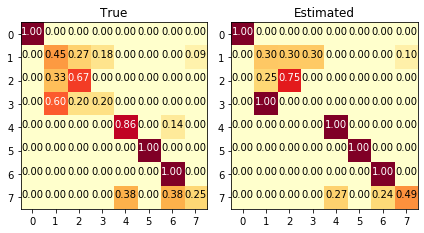

D (based on Jensen Shannon) = 0.047879454052253335
D (based on normalized Frobenius) = 0.0806756317615509


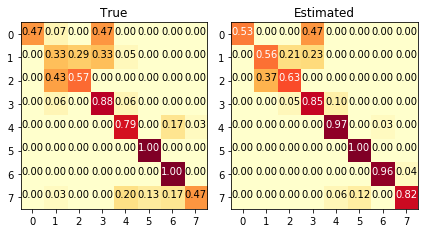

D (based on Jensen Shannon) = 0.049840050897631515
D (based on normalized Frobenius) = 0.0709938183426857


In [109]:
prob_Yzt = R_model.get_confusionM() # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [110]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.17181396204863447
Individual D_NormF =  0.14279361201797502


#### C-MoA

Plot 5 random matrices from the set


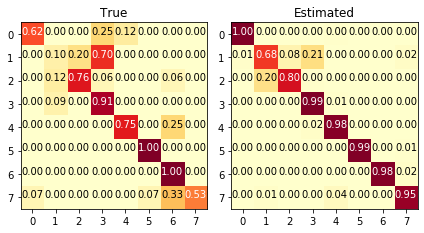

D (based on Jensen Shannon) = 0.13333277132973523
D (based on normalized Frobenius) = 0.13932441008873864


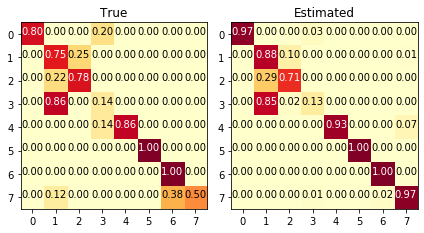

D (based on Jensen Shannon) = 0.05937812962771182
D (based on normalized Frobenius) = 0.08855696971064486


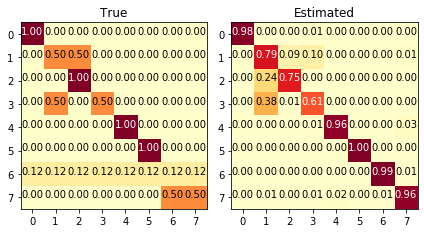

D (based on Jensen Shannon) = 0.17235314725099216
D (based on normalized Frobenius) = 0.16454138213986108


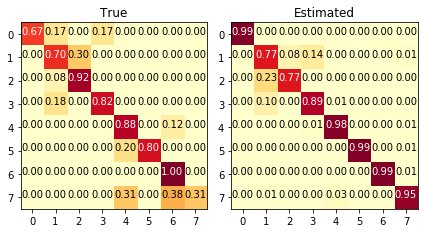

D (based on Jensen Shannon) = 0.11893984905323077
D (based on normalized Frobenius) = 0.12674637831775135


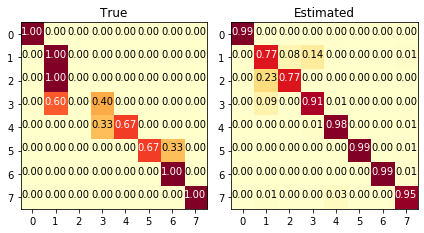

D (based on Jensen Shannon) = 0.1653198365724449
D (based on normalized Frobenius) = 0.18607829604174153


In [111]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Yzt = CMOA_model.get_ann_confusionM(A) # estimate of conf_matrix_I

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [112]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.21964091630656604
Individual D_NormF =  0.17464322413187133


#### CMM could estimates individual matrices 

Plot 5 random matrices from the set


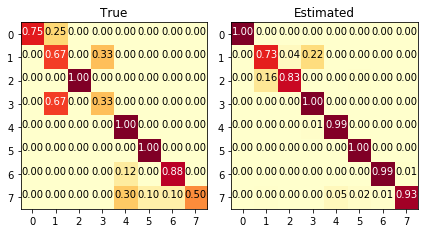

D (based on Jensen Shannon) = 0.12207750657429887
D (based on normalized Frobenius) = 0.1466240418197508


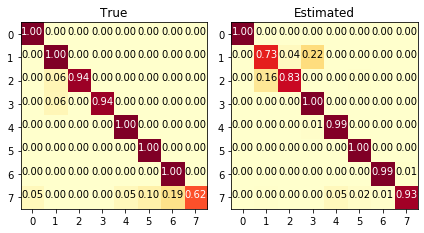

D (based on Jensen Shannon) = 0.04512257977448255
D (based on normalized Frobenius) = 0.06707006407693246


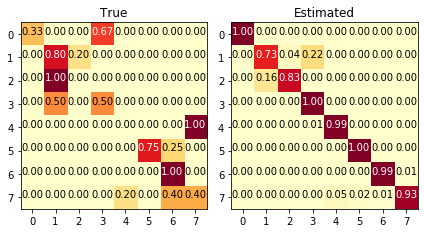

D (based on Jensen Shannon) = 0.3796481687316231
D (based on normalized Frobenius) = 0.2911500015566223


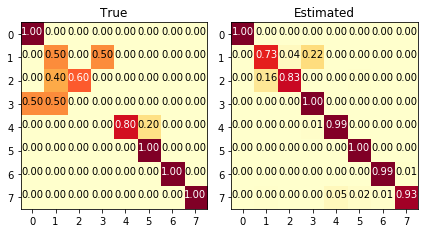

D (based on Jensen Shannon) = 0.16080972917847108
D (based on normalized Frobenius) = 0.16898593543600918


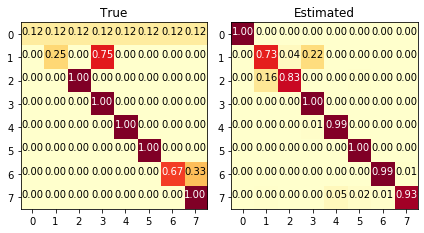

D (based on Jensen Shannon) = 0.15305618256118697
D (based on normalized Frobenius) = 0.1607585246217449


In [113]:
prob_Yzt = []
for t in range(y_obs.shape[1]):
    conf = CMM_model.get_ann_confusionM(Xstd_train, y_obs[:,t])
    
    prob_Yzt.append(conf)
prob_Yzt = np.asarray(prob_Yzt)

compare_set_conf_ma(prob_Yzt, true_set_conf_ma = conf_matrix_I, text=True, n_samp=5)

In [114]:
print("Individual D_JS = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_JS))
print("Individual D_NormF = ",Individual_D(conf_matrix_I, prob_Yzt, D=D_NormF))

Individual D_JS =  0.25795908990516725
Individual D_NormF =  0.19971322223225732


#### C-MoA could estimates global matrices 

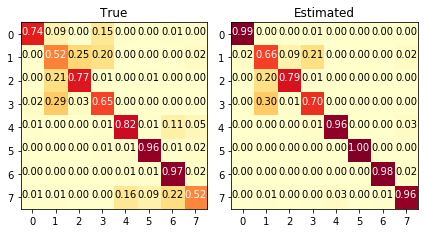

In [115]:
A = np.unique(np.concatenate(A_idx_var)).reshape(-1,1)
prob_Gt = CMOA_model.get_predictions_g(A)

prob_Yz = CMOA_model.get_global_confusionM(prob_Gt)

compare_conf_ma(prob_Yz, true_conf_mat = confe_matrix_G, text=True)

In [116]:
print("Global D (based on Jensen Shannon) =",D_JS(confe_matrix_G, prob_Yz))
print("Global D (based on normalized Frobenius) =",D_NormF(confe_matrix_G, prob_Yz))

Global D (based on Jensen Shannon) = 0.06240330116293328
Global D (based on normalized Frobenius) = 0.0821379850510367


### The behaviors of the groups found by CMM and CMOA

In [23]:
from codeE.evaluation import I_sim, R_score, H_conf, S_score, S_bias

**For CMM**
Group  1


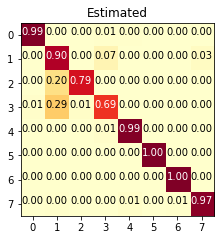

Expertise Identity (I_sim) = 0.9540979828771412
Expertise Diagonal (R_score) = 0.9160896116831443
Randomness (H_conf) = 0.11552080874812563
Spammer score (S_score) = 0.9041024133521649
Bias for class index 1 with score = 0.007012
-------------------------------------------------
Group  2


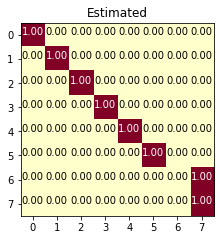

Expertise Identity (I_sim) = 0.8750044855008429
Expertise Diagonal (R_score) = 0.8749989728907885
Randomness (H_conf) = 1.714886540678934e-05
Spammer score (S_score) = 0.8571416833037584
Bias for class index 7 with score = 0.083329
-------------------------------------------------
Group  3


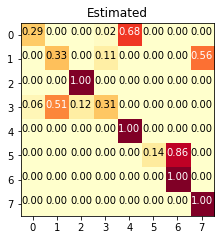

Expertise Identity (I_sim) = 0.7314065052352612
Expertise Diagonal (R_score) = 0.6333088773048708
Randomness (H_conf) = 0.19119125100340648
Spammer score (S_score) = 0.5809244312055666
Bias for class index 6 with score = 0.102594
-------------------------------------------------


In [27]:
print("**For CMM**")

B = CMM_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")

**For C-MoA**
Group  1


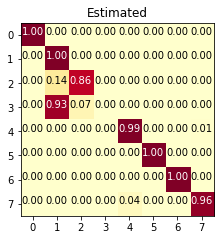

Expertise Identity (I_sim) = 0.8632872289684169
Expertise Diagonal (R_score) = 0.8521544584971488
Randomness (H_conf) = 0.05113411915677229
Spammer score (S_score) = 0.8310336668538842
Bias for class index 1 with score = 0.086416
-------------------------------------------------
Group  2


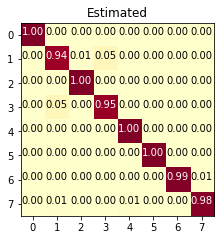

Expertise Identity (I_sim) = 0.9905997651136185
Expertise Diagonal (R_score) = 0.9815206040182208
Randomness (H_conf) = 0.03926926427596057
Spammer score (S_score) = 0.9788806903065381
Bias for class index 4 with score = 0.000009
-------------------------------------------------
Group  3


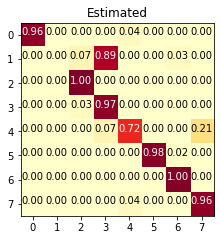

Expertise Identity (I_sim) = 0.8469872752820234
Expertise Diagonal (R_score) = 0.8233608767601719
Randomness (H_conf) = 0.10381542823266675
Spammer score (S_score) = 0.7981267162973391
Bias for class index 3 with score = 0.083390
-------------------------------------------------


In [28]:
print("**For C-MoA**")

B = CMOA_model.get_confusionM()

for i, b in enumerate(B):
    print("Group ",(i+1))
    compare_conf_ma(b, text=True)

    print("Expertise Identity (I_sim) =", I_sim(b))
    print("Expertise Diagonal (R_score) =", R_score(b))
    print("Randomness (H_conf) =", H_conf(b))
    print("Spammer score (S_score) =", S_score(b))
    print("Bias for class index %d with score = %f"%(S_bias(b)))
    print("-------------------------------------------------")